# 反向神经网络

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import OneHotEncoder
from scipy.optimize import minimize

In [2]:
data = loadmat('ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
X = data['X']
y = data['y']
X.shape, y.shape

((5000, 400), (5000, 1))

对y标签进行一次one-hot编码

In [4]:
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [5]:
y[0], y_onehot[0,:]

(array([10], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

In [6]:
def display_data(data):
    """数据集可视化展示"""
    (m, n) = data.shape
    example_width = np.round(np.sqrt(n)).astype(int)
    example_height = (n / example_width).astype(int)
    display_rows = np.floor(np.sqrt(m)).astype(int)
    display_cols = np.ceil(m / display_rows).astype(int)
    pad = 1
    display_array = - np.ones((pad + display_rows * (example_height + pad),
                               pad + display_rows * (example_height + pad)))
    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex > m:
                break
            max_val = np.max(np.abs(data[curr_ex]))
            display_array[pad + j * (example_height + pad) + np.arange(example_height),
                          pad + i * (example_width + pad) + np.arange(example_width)[:, np.newaxis]] = \
                data[curr_ex].reshape((example_height, example_width)) / max_val
            curr_ex += 1
        if curr_ex > m:
            break
    plt.figure()
    plt.imshow(display_array, cmap='gray', extent=[-1, 1, -1, 1])
    plt.axis('off')
    plt.show()

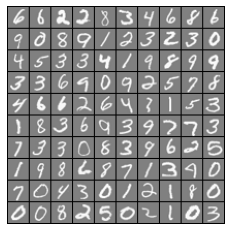

In [7]:
m = y.size  # 样本数 5000
# 随机选100个样本 可视化
rand_indices = np.random.permutation(range(m))
selected = X[rand_indices[:100], :]
display_data(selected)

# Sigmoid函数

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 前向传播函数

In [9]:
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = a1.dot(theta1.T)
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2.dot(theta2.T)
    h = sigmoid(z3)
    return a1, z2, a2, z3, h

# 代价函数

In [10]:
def cost(params, input_size, hidden_size, num_labels, X, y):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    theta1 = np.matrix(np.reshape(params[:hidden_size*(input_size+1)],(hidden_size,(input_size+1))))
    theta2 = np.matrix(np.reshape(params[hidden_size*(input_size+1):],(num_labels,(hidden_size+1))))
    a1, z2 ,a2, z3, h = forward_propagate(X, theta1, theta2)
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:],np.log(h[i,:]))
        second_term = np.multiply((1-y[i,:]),np.log(1-h[i,:]))
        J += np.sum(first_term - second_term)
    J = J / m
    return J    

前向传播函数计算给定当前参数的每个训练实例的假设, 它的输出形状应该与y的一个one-hot编码相同。 

In [11]:
# 初始化设置
input_size = 400
hidden_size = 25
num_labels = 10
learning_rate = 1
# 随机初始化完整网络参数大小的参数数组
params = (np.random.random(size=hidden_size*(input_size+1)+num_labels*(hidden_size+1))-0.5)*0.25
m = X.shape[0]
X = np.matrix(X)
y = np.matrix(y)
# 将参数数组解开为每个层的参数矩阵
theta1 = np.matrix(np.reshape(params[:hidden_size*(input_size+1)],(hidden_size,(input_size+1))))
theta2 = np.matrix(np.reshape(params[hidden_size*(input_size+1):],(num_labels,(hidden_size+1))))
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [12]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

代价函数在计算假设矩阵h之后，应用代价函数来计算y和h之间的总误差

In [13]:
cost(params, input_size, hidden_size, num_labels, X, y_onehot)

7.174086196196091

# 正则化代价函数

In [14]:
def costReg(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    theta1 = np.matrix(np.reshape(params[:hidden_size*(input_size+1)],(hidden_size,(input_size+1))))
    theta2 = np.matrix(np.reshape(params[hidden_size*(input_size+1):],(num_labels,(hidden_size+1))))
    a1, z2 ,a2, z3, h = forward_propagate(X, theta1, theta2)
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:],np.log(h[i,:]))
        second_term = np.multiply((1-y[i,:]),np.log(1-h[i,:]))
        J += np.sum(first_term - second_term)
    J = J / m
    J += (float(learning_rate) / (2 * m))*(np.sum(np.power(theta1[:,1:],2))+np.sum(np.power(theta2[:,1:],2)))
    return J

# 反向传播算法

Sigmoid函数梯度计算函数

In [15]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1-sigmoid(z)))

通过反向传播算法计算代价和梯度

In [16]:
def backprop(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)

    theta1 = np.matrix(np.reshape(params[:hidden_size*(input_size+1)],(hidden_size,(input_size+1))))
    theta2 = np.matrix(np.reshape(params[hidden_size*(input_size+1):],(num_labels,(hidden_size+1))))
    
    a1,z2,a2,z3,h=forward_propagate(X,theta1,theta2)
   
    J = 0
    delta1 = np.zeros(theta1.shape)
    delta2 = np.zeros(theta2.shape)

    for i in range(m):
        first_term = np.multiply(-y[i,:],np.log(h[i,:]))
        second_term = np.multiply((1-y[i,:]),np.log(1-h[i,:]))
        J += np.sum(first_term-second_term)
    
    J = J / m

    J += (float(learning_rate) / (2*m))*(np.sum(np.power(theta1[:,1:],2))+np.sum(np.power(theta2[:,1:],2)))

    for t in range(m):
        a1t = a1[t,:] # (1, 401)
        z2t = z2[t,:] # (1, 25)
        a2t = a2[t,:] # (1, 26)
        ht = h[t,:] # (1, 10)
        yt = y[t,:] # (1, 10)

        d3t = ht - yt # (1, 10)

        z2t = np.insert(z2t, 0, values=np.ones(1))
        d2t = np.multiply((theta2.T*d3t.T).T,sigmoid_gradient(z2t)) # (1, 26)

        delta1 = delta1 + (d2t[:,1:]).T*a1t
        delta2 = delta2 + d3t.T*a2t

    delta1 = delta1 / m
    delta2 = delta2 / m

    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))

    return J, grad

正则化的反向梯度

In [17]:
def backpropReg(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)

    theta1 = np.matrix(np.reshape(params[:hidden_size*(input_size+1)],(hidden_size,(input_size+1))))
    theta2 = np.matrix(np.reshape(params[hidden_size*(input_size+1):],(num_labels,(hidden_size+1))))
    
    a1,z2,a2,z3,h=forward_propagate(X,theta1,theta2)
   
    J = 0
    delta1 = np.zeros(theta1.shape)
    delta2 = np.zeros(theta2.shape)

    for i in range(m):
        first_term = np.multiply(-y[i,:],np.log(h[i,:]))
        second_term = np.multiply((1-y[i,:]),np.log(1-h[i,:]))
        J += np.sum(first_term-second_term)
    
    J = J / m

    J += (float(learning_rate) / (2*m))*(np.sum(np.power(theta1[:,1:],2))+np.sum(np.power(theta2[:,1:],2)))

    for t in range(m):
        a1t = a1[t,:] # (1, 401)
        z2t = z2[t,:] # (1, 25)
        a2t = a2[t,:] # (1, 26)
        ht = h[t,:] # (1, 10)
        yt = y[t,:] # (1, 10)

        d3t = ht - yt # (1, 10)

        z2t = np.insert(z2t, 0, values=np.ones(1))
        d2t = np.multiply((theta2.T*d3t.T).T,sigmoid_gradient(z2t)) # (1, 26)

        delta1 = delta1 + (d2t[:,1:]).T*a1t
        delta2 = delta2 + d3t.T*a2t

    delta1 = delta1 / m
    delta2 = delta2 / m

    delta1[:,1:]=delta1[:,1:]+(theta1[:,1:]*learning_rate) / m
    delta2[:,1:]=delta2[:,1:]+(theta2[:,1:]*learning_rate) / m

    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))

    return J, grad

In [18]:
J, grad = backprop(params,input_size,hidden_size,num_labels,X,y_onehot,learning_rate)
J, grad.shape

(7.179454801808508, (10285,))

用训练好的网络进行预测

In [19]:
fmin = minimize(fun=backprop, x0=params,args=(input_size,hidden_size,num_labels,X,y_onehot,learning_rate),
                method='TNC',jac=True,options={'maxiter':250})
fmin

     fun: 0.44388858533296915
     jac: array([ 1.44784894e-04,  0.00000000e+00,  0.00000000e+00, ...,
       -3.60716317e-04, -1.00937566e-04,  6.46486392e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 251
     nit: 17
  status: 3
 success: False
       x: array([ 0.10467883,  0.09897447, -0.069782  , ..., -2.29748678,
       -1.90223488, -2.81616197])

'''由于目标函数不太可能完全收敛，我们对迭代次数进行了限制。 我们的总代价已经下降到0.5以下，这是算法正常工作的一个很好的指标。 让我们使用它发现的参数，并通过网络转发，以获得一些预测。

让我们使用它找到的参数，并通过网络前向传播以获得预测。'''

In [20]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size*(input_size+1)],(hidden_size,(input_size+1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size*(input_size+1):],(num_labels,(hidden_size+1))))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
y_pred = np.array(np.argmax(h,axis=1)+1)
y_pred

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=int64)

通过计算准确度，查看神经网络的训练效果

In [22]:
correct = [1 if a == b else 0 for (a,b) in zip(y_pred,y)]
accuracy = (sum(map(int,correct)) / float(len(correct)))
print('accuracy = {0}%'.format(accuracy*100))

accuracy = 98.72%
